# **Peanut Image Denoising Autoencoder**

Oleh: Crista Livia Budiman

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Dropout, UpSampling2D, Add, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import cv2
import os
import zipfile
from glob import glob
import warnings
warnings.filterwarnings('ignore')

SEED_VALUE = 42
np.random.seed(SEED_VALUE)
random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [ ]:
with zipfile.ZipFile('encoder.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

DATASET_PATH = 'data'

In [ ]:
image_folder = os.path.join(DATASET_PATH, 'B_23')
image_paths = glob(os.path.join(image_folder, '*.jpg'))

#**EDA**

In [ ]:
shapes = []
heights = []
widths = []
channels = []
min_pixel_values = []
max_pixel_values = []

for path in image_paths:
    img = cv2.imread(path)
    if img is not None:
        shapes.append(img.shape)
        heights.append(img.shape[0])
        widths.append(img.shape[1])
        channels.append(img.shape[2])
        min_pixel_values.append(img.min())
        max_pixel_values.append(img.max())

image_info = {
    'Total Images': len(image_paths),
    'Range Height': (min(heights) if heights else None, max(heights) if heights else None),
    'Range Width': (min(widths) if widths else None, max(widths) if widths else None),
    'Channels': list(set(channels)) if channels else None,
    'Pixel Value Range': (min(min_pixel_values) if min_pixel_values else None, max(max_pixel_values) if max_pixel_values else None)
    }

for key, value in image_info.items():
    print(f"{key}: {value}")

Total Images: 1074
Range Height: (600, 600)
Range Width: (600, 600)
Channels: [3]
Pixel Value Range: (np.uint8(0), np.uint8(255))


**EDA pertama yang dilakukan adalah mengecek total gambar, shape, dan jumlah channel dari dataset.**

Melalui EDA tersebut, dapat diketahui bahwa dataset berisi 1.074 gambar total, sizenya 600 x 600 pixel, memiliki 3 channel (RGB), dan range pixel nya dari rentang 0-255.

Informasi ini sangat penting karena menunjukkan bahwa semua gambar memiliki dimensi dan format yang konsisten, sehingga tidak perlu penyesuaian size saat digunakan sebagai input ke dalam model. EDA seperti ini menjadi langkah awal yang penting untuk memastikan kualitas dan kesesuaian data, sehingga proses analisis dan training model berikutnya dapat berjalan lebih akurat.

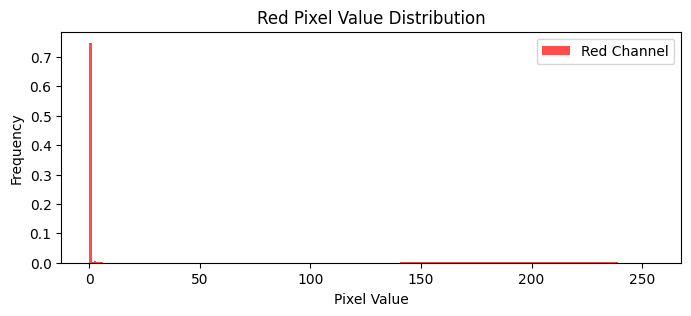

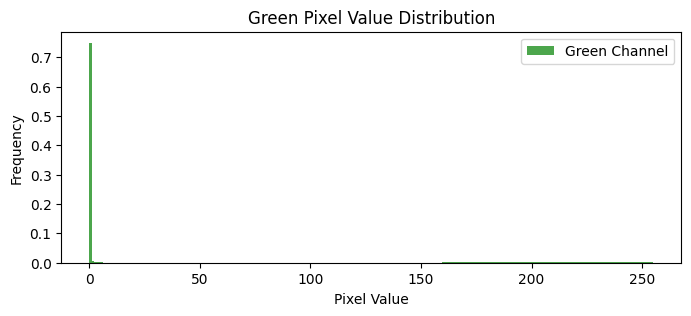

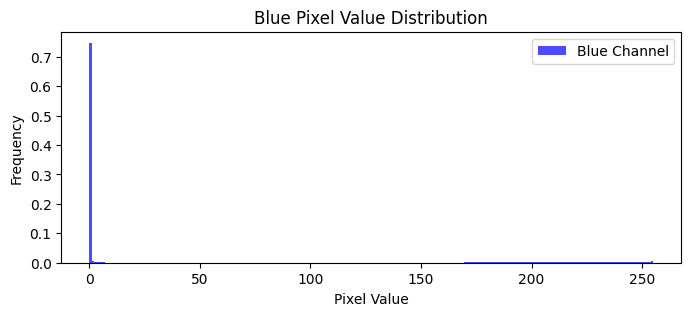

In [ ]:
all_pixels = []

for path in image_paths:
    img = cv2.imread(path)
    if img is not None:
        all_pixels.append(img.reshape(-1, 3))

if all_pixels:
    all_pixels = np.concatenate(all_pixels, axis=0)

    channels = ['Red', 'Green', 'Blue']
    colors = ['red', 'green', 'blue']

    for i in range(3):
      plt.figure(figsize=(8, 3))
      plt.hist(all_pixels[:, i], bins=256, alpha=0.7, color=colors[i], label=f'{channels[i]} Channel', density=True)
      plt.title(f'{channels[i]} Pixel Value Distribution')
      plt.xlabel('Pixel Value')
      plt.ylabel('Frequency')
      plt.legend()
      plt.show()

**EDA kedua yang dilakukan adalah mengecek distribusi nilai piksel pada channel RGB.**

Melalui EDA tersebut, dapat diketahui bahwa sebagian besar nilai piksel pada ketiga channel RGB tersebut bernilai 0. Hal ini berarti mayoritas area gambar didominasi oleh warna latar belakang hitam. Terdapat sangat sedikit nilai di bawah 0.1 pada setiap nilai, yang kemungkinan besar mengindikasikan bahwa itu adalah warna objeknya.

Informasi ini penting untuk diketahui karena memberikan gambaran awal bahwa dataset memiliki rasio latar belakang yang besar dibandingkan objek utama. EDA seperti ini juga bisa membantu dalam proses segmentasi objek, terutama ketika distribusi warna memiliki perbedaan yang signifikan antara objek dan latar.

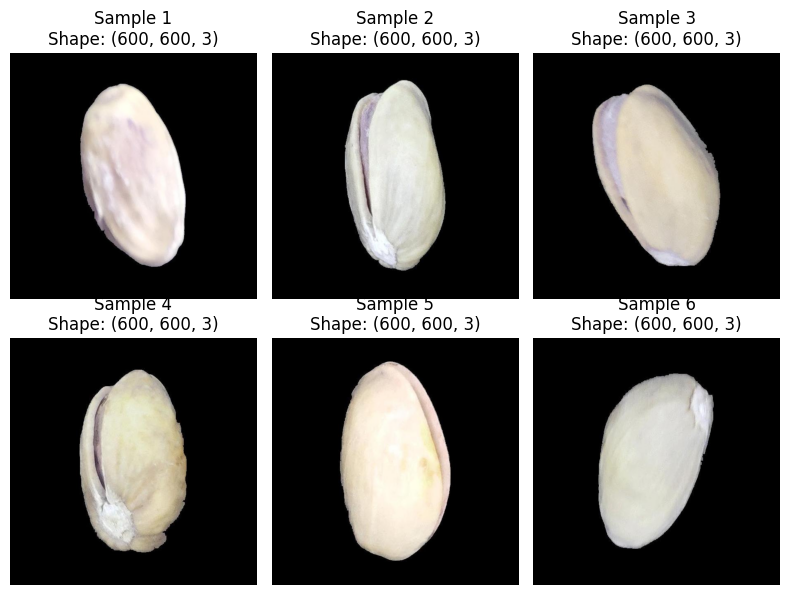

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(8, 6))
for i in range(min(6, len(image_paths))):
  img = cv2.imread(image_paths[i])
  if img is not None:
    row = i // 3
    col = i % 3
    axes[row, col].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[row, col].set_title(f'Sample {i+1}\nShape: {img.shape}')
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

**EDA ketiga yang dilakukan adalah melihat gambar sampel beserta dimensi gambarnya.**

Melalui EDA tersebut, dapat diketahui bahwa dataset berisi gambar objek kacang sebesar 600 x 600 piksel dan 3 channel warna (RGB). Setiap gambar menampilkan satu objek yang terletak di tengah dengan latar belakang hitam yang bersih dan seragam. Dari enam contoh gambar yang ditampilkan, dapat dilihat bahwa objek memiliki beberapa variasi tetapi tetap dalam posisi yang konsisten.

Informasi ini sangat penting karena menunjukkan bahwa gambar-gambar dalam dataset memiliki dimensi, komposisi, dan kualitas visual yang sama.  Selain itu, posisi objek yang konsisten membuat proses training fitur oleh model menjadi lebih efektif.


#**Preprocessing**

* Split data: 80% training, 10% validasi, dan 10% testing
* Resize image: 100 x 100
* Gaussian noise: mean 0; std 0.1

## Splitting

In [ ]:
all_images = []
for path in image_paths:
    img = cv2.imread(path)
    if img is not None:
        all_images.append(img)

all_images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in all_images]

In [ ]:
random.shuffle(image_paths)
trainval, test = train_test_split(all_images, test_size=0.1, random_state=42)
train, val = train_test_split(trainval, test_size=1/9, random_state=42)

total = len(train) + len(val) + len(test)
print("Train:", len(train), f"({len(train)/total:.2%})")
print("Val:", len(val), f"({len(val)/total:.2%})")
print("Test:", len(test), f"({len(test)/total:.2%})")

Train: 858 (79.89%)
Val: 108 (10.06%)
Test: 108 (10.06%)


## Resize image

In [ ]:
resize_shape = (100, 100)
train = np.array([cv2.resize(img, resize_shape).astype(np.float32) / 255.0 for img in train])
val = np.array([cv2.resize(img, resize_shape).astype(np.float32) / 255.0 for img in val])
test = np.array([cv2.resize(img, resize_shape).astype(np.float32) / 255.0 for img in test])


## Gaussian Noise

In [ ]:
train_noise = np.clip(train + np.random.normal(0.0, 0.1, train.shape), 0., 1.)
val_noise = np.clip(val + np.random.normal(0.0, 0.1, val.shape), 0., 1.)
test_noise = np.clip(test + np.random.normal(0.0, 0.1, test.shape), 0., 1.)

In [ ]:
train_mean = np.mean(train)
train_std = np.std(train)
val_mean = np.mean(val)
val_std = np.std(val)
test_mean = np.mean(test)
test_std = np.std(test)

train_noise_mean = np.mean(train_noise)
train_noise_std = np.std(train_noise)
val_noise_mean = np.mean(val_noise)
val_noise_std = np.std(val_noise)
test_noise_mean = np.mean(test_noise)
test_noise_std = np.std(test_noise)

print("Before Applying Gaussian Noise")
print(f"Train Mean: {train_mean:.4f}, Train Std: {train_std:.4f}")
print(f"Val Mean: {val_mean:.4f}, Val Std: {val_std:.4f}")
print(f"Test Mean: {test_mean:.4f}, Test Std: {test_std:.4f}")
print("\n")
print("After Applying Gaussian Noise")
print(f"Train Noise Mean: {train_noise_mean:.4f}, Train Noise Std: {train_noise_std:.4f}")
print(f"Val Noise Mean: {val_noise_mean:.4f}, Val Noise Std: {val_noise_std:.4f}")
print(f"Test Noise Mean: {test_noise_mean:.4f}, Test Noise Std: {test_noise_std:.4f}")

Before Applying Gaussian Noise
Train Mean: 0.1906, Train Std: 0.3453
Val Mean: 0.1886, Val Std: 0.3427
Test Mean: 0.1862, Test Std: 0.3397


After Applying Gaussian Noise
Train Noise Mean: 0.2194, Train Noise Std: 0.3327
Val Noise Mean: 0.2176, Val Noise Std: 0.3304
Test Noise Mean: 0.2152, Test Noise Std: 0.3277


#**Training**

In [ ]:
input_shape = (100, 100, 3)
input_layer = Input(shape=input_shape, name='input_layer')

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)]
epochs = 50
batch_size = 32

## Baseline Model

In [ ]:
conv2d = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2d')(input_layer)
max_pooling2d = MaxPooling2D((2, 2), padding='same', name='max_pooling2d')(conv2d)
conv2d_1 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2d_1')(max_pooling2d)
max_pooling2d_1 = MaxPooling2D((2, 2), padding='same', name='max_pooling2d_1')(conv2d_1)
conv2d_2 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2d_2')(max_pooling2d_1)

up_sampling2d = UpSampling2D((2, 2), name='up_sampling2d')(conv2d_2)
conv2d_3 = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2d_3')(up_sampling2d)
up_sampling2d_1 = UpSampling2D((2, 2), name='up_sampling2d_1')(conv2d_3)
conv2d_4 = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='conv2d_4')(up_sampling2d_1)

In [ ]:
autoencoder = Model(input_layer, conv2d_4, name='autoencoder')

autoencoder.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 100, 100, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = autoencoder.fit(
    train_noise, train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(val_noise, val),
    callbacks=callbacks
)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 0.1242 - mae: 0.2966 - val_loss: 0.0137 - val_mae: 0.0494
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0125 - mae: 0.0462 - val_loss: 0.0606 - val_mae: 0.1124
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 0.0319 - mae: 0.0716 - val_loss: 0.0148 - val_mae: 0.0492
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 0.0130 - mae: 0.0463 - val_loss: 0.0101 - val_mae: 0.0406
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0079 - mae: 0.0343 - val_loss: 0.0042 - val_mae: 0.0245
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 0.0041 - mae: 0.0239 - val_loss: 0.0036 - val_mae: 0.0222
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - loss: 0.0036 - mae: 0.0224 - val_loss: 0.0034 - val_mae: 0.0212
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 0.0034 - mae: 0.0214 - val_loss: 0.0031 - val_mae: 0.0203
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - loss: 0.0031 - mae: 

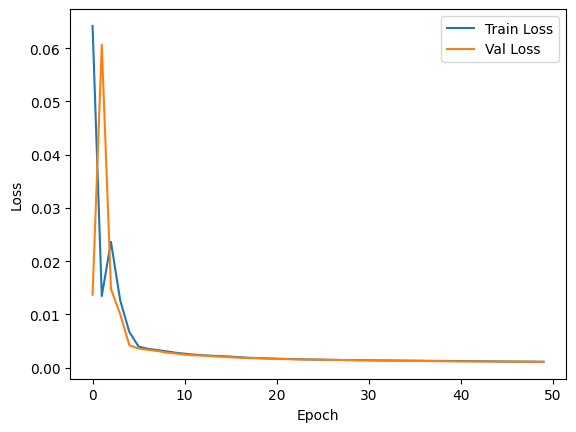

In [ ]:
base_train_loss = history.history['loss']
base_val_loss = history.history['val_loss']
plt.plot(base_train_loss,label="Train Loss")
plt.plot(base_val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Grafik menunjukkan bahwa nilai loss untuk data training dan val menurun tajam di awal, kemudian stabil mendekati nol seiring bertambahnya epoch, yang menunjukkan bahwa model baseline sudah berhasil belajar dengan baik tanpa overfitting.

## Modified Model


In [ ]:
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D((2, 2), padding='same')(conv2)

# Bottleneck
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)

# Decoder
up1 = UpSampling2D((2, 2))(conv3)
up1 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
up1 = Add()([up1, conv2])  # skip connection

up2 = UpSampling2D((2, 2))(up1)
up2 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
up2 = Add()([up2, conv1])  # skip connection

output_layer = Conv2D(3, (3, 3), activation='linear', padding='same')(up2)

In [ ]:
autoencoder_modified = Model(input_layer, output_layer)

autoencoder_modified.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

autoencoder_modified.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 100, 100,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 100, 100,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 50, 50,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 50, 50,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 50, 50,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 25, 25,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 25, 25,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 50, 50,    │          0 │ conv2d_4[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 50, 50,    │     73,792 │ up_sampling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 50, 50,    │          0 │ conv2d_5[0][0],   │
│                     │ 64)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 100, 100,  │          0 │ add[0][0]         │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 100, 100,  │     18,464 │ up_sampling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 100, 100,  │          0 │ conv2d_6[0][0],   │
│                     │ 32)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 100, 100,  │        867 │ add_1[0][0]       │
│                     │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 232,547 (908.39 KB)

 Trainable params: 232,547 (908.39 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_modified = autoencoder_modified.fit(
    train_noise, train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(val_noise, val),
    callbacks=callbacks
)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 115s 4s/step - loss: 0.0357 - mae: 0.1025 - val_loss: 0.0030 - val_mae: 0.0279
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 112s 4s/step - loss: 0.0025 - mae: 0.0259 - val_loss: 0.0018 - val_mae: 0.0228
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 113s 4s/step - loss: 0.0017 - mae: 0.0222 - val_loss: 0.0013 - val_mae: 0.0203
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - loss: 0.0012 - mae: 0.0198 - val_loss: 9.8293e-04 - val_mae: 0.0181
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - loss: 9.3325e-04 - mae: 0.0178 - val_loss: 8.0690e-04 - val_mae: 0.0166
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 145s 4s/step - loss: 7.7321e-04 - mae: 0.0163 - val_loss: 6.9803e-04 - val_mae: 0.0154
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - loss: 6.7315e-04 - mae: 0.0151 - val_loss: 6.1472e-04 - val_mae: 0.0143
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - loss: 6.0199e-04 - mae: 0.0142 - val_loss: 5.4833e-04 - val_mae: 0.0134
Epoch 9/50
27/27 ━━━━━━━━━━━

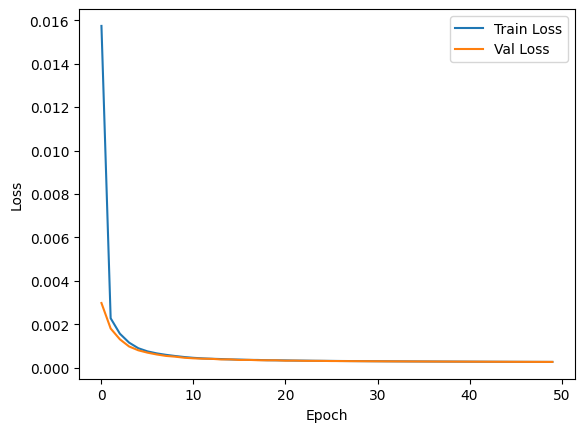

In [ ]:
modified_train_loss = history_modified.history['loss']
modified_val_loss = history_modified.history['val_loss']
plt.plot(modified_train_loss,label="Train Loss")
plt.plot(modified_val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Grafik menunjukkan bahwa nilai loss untuk data training turun drastis, kemudian terdapat pola yang konsisten antara train loss dan val loss mendekati 0, yang mengindikasikan bahwa model ini juga belajar dengan baik dan tidak mengalami overfitting.

#**Evaluasi**

In [ ]:
pred_baseline = autoencoder.predict(test_noise)
pred_modified = autoencoder_modified.predict(test_noise)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 332ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 876ms/step


In [ ]:
def calculate_ssim_list(actual, predict):
    ssim_scores = []
    for i in range(len(actual)):
        score = ssim(actual[i], predict[i], channel_axis=2, data_range=1.0)
        ssim_scores.append(score)
    return ssim_scores

ssim_baseline = calculate_ssim_list(test, pred_baseline)
ssim_modified = calculate_ssim_list(test, pred_modified)

print(f"SSIM Baseline Mean: {np.mean(ssim_baseline):.4f}")
print(f"SSIM Modifikasi Mean: {np.mean(ssim_modified):.4f}")

SSIM Baseline Mean: 0.9379
SSIM Modifikasi Mean: 0.9637


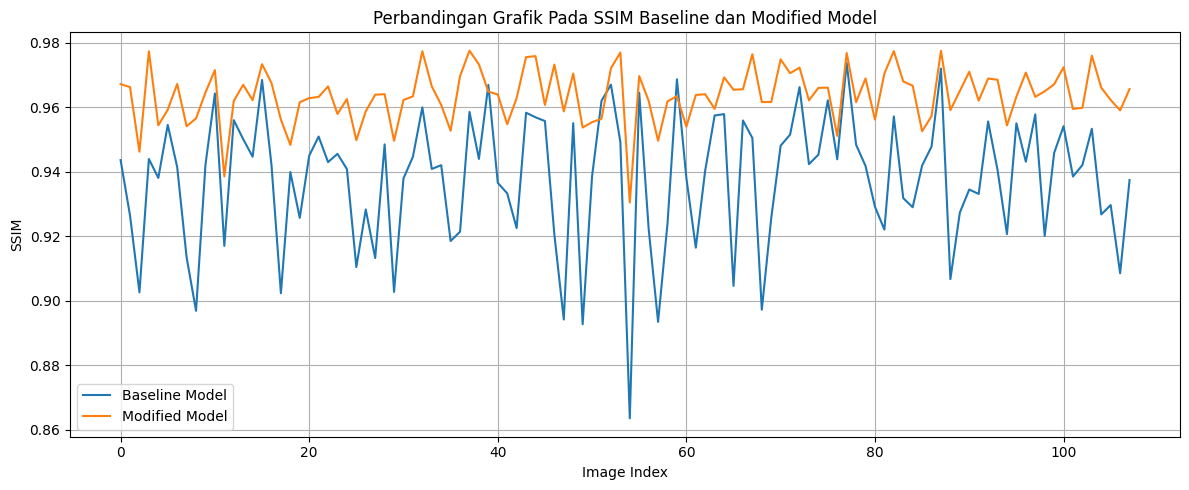

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(ssim_baseline, label='Baseline Model')
plt.plot(ssim_modified, label='Modified Model')
plt.xlabel('Image Index')
plt.ylabel('SSIM')
plt.title('Perbandingan Grafik Pada SSIM Baseline dan Modified Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Berdasarkan hasil perhitungan SSIM, diketahui bahwa Modified Model memiliki nilai rata-rata sebesar 0.9637, lebih tinggi dibandingkan dengan Baseline Model yang memperoleh nilai 0.9379. Selain itu, pada plot perbandingan SSIM, terlihat bahwa Modified Model tidak hanya memiliki nilai SSIM yang lebih tinggi, tetapi juga lebih stabil dan konsisten di berbagai sampel. Sebaliknya, Baseline Model menunjukkan fluktuasi yang cukup besar.

Oleh karena itu, dapat disimpulkan bahwa Modified Model memiliki performa yang lebih reliabel dalam merekonstruksi gambar secara menyeluruh, serta lebih akurat dan efektif dalam mempertahankan detail penting dari gambar aslinya.



Hal tersebut juga dapat dilihat pada gambar di bawah ini.

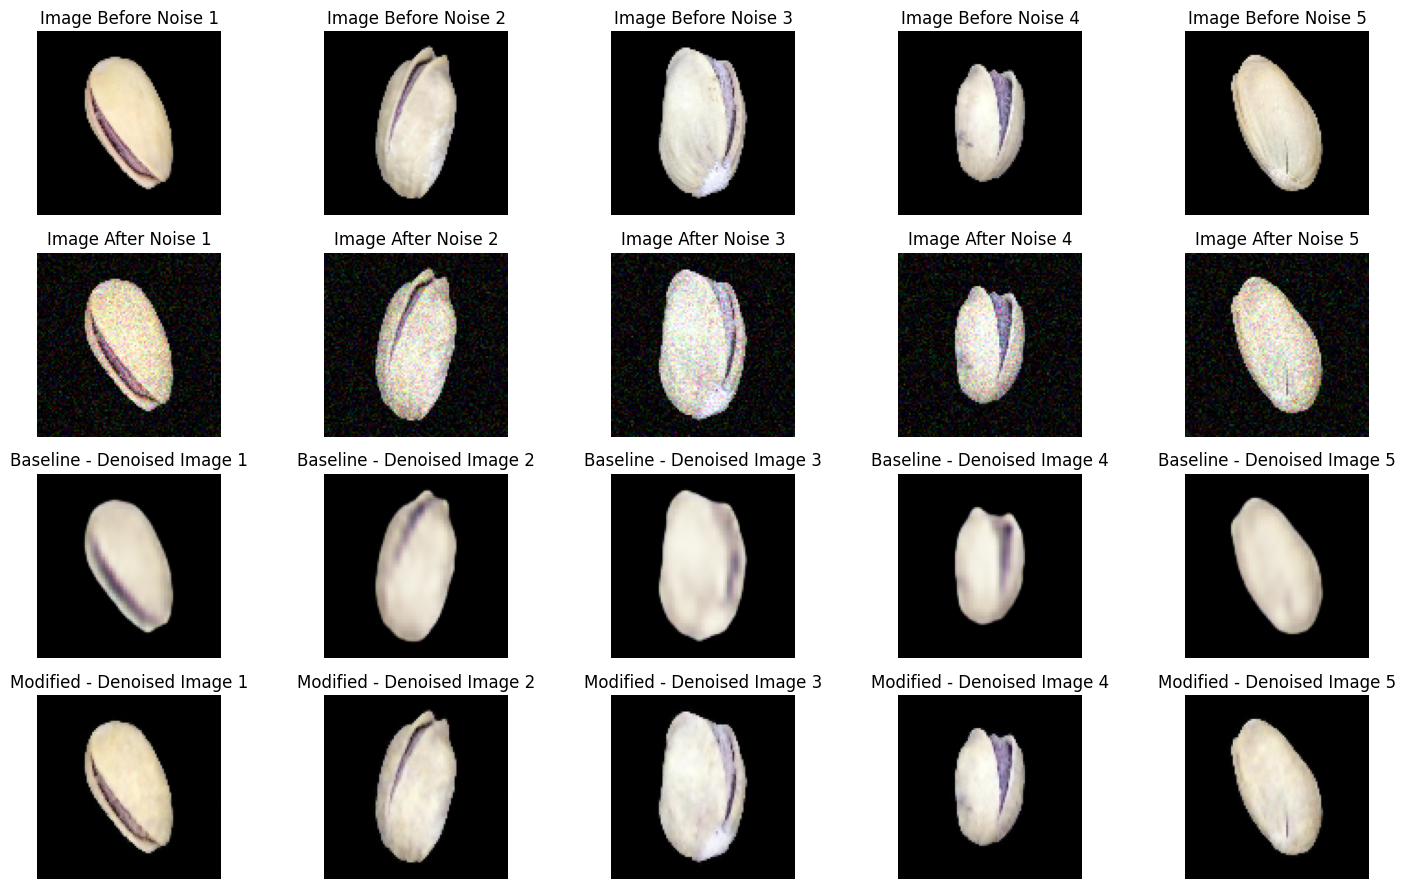

In [ ]:
num_samples = 5
fig, axes = plt.subplots(4, num_samples, figsize=(15, 9))

for i in range(num_samples):
    axes[0, i].imshow(test[i])
    axes[0, i].set_title(f'Image Before Noise {i+1}')
    axes[0, i].axis('off')

    axes[1, i].imshow(test_noise[i])
    axes[1, i].set_title(f'Image After Noise {i+1}')
    axes[1, i].axis('off')

    axes[2, i].imshow(pred_baseline[i])
    axes[2, i].set_title(f'Baseline - Denoised Image {i+1}')
    axes[2, i].axis('off')

    axes[3, i].imshow(pred_modified[i])
    axes[3, i].set_title(f'Modified - Denoised Image {i+1}')
    axes[3, i].axis('off')

plt.tight_layout()
plt.show()

Gambar di atas menunjukkan proses denoising dari lima sampel gambar  menggunakan Baseline dan Modified Model.

1. Baris pertama adalah gambar asli sebelum diberi noise

2. Baris kedua adalah  gambar setelah ditambahkan noise

3. Baris ketiga adalah hasil denoising oleh Baseline Model

4. Baris ketiga adalah hasil denoising oleh Modified Model

Dari hasil tersebut, dapat dilihat bahwa Modified Model mampu menghasilkan gambar rekonstruksi dengan detail dan tekstur yang lebih baik dibandingkan Baseline Model. Gambar Baseline Model terlihat lebih buram dan cenderung kehilangan beberapa detail penting dari gambar aslinya.